In [107]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Soving Cahn-Hilliard equations
## Cahn-Hilliard equations
$$\partial_t c=m\nabla^2 \mu$$
$$\mu = \frac{b}{(\Delta c)^2}(c-c^{(0)}_+)(c-c^{(0)}_-)(2c-c^{(0)}_- - c^{(0)}_+) - \kappa \nabla^2 c$$

### Nonnormalization
Normalize concentration, length and time by $\Delta c=c^{(0)}_--c^{(0)}_+$, $\hat{\omega}=2(\kappa /b)^{1/2}$ and $t_0=\hat{\omega}^2/D$ ($D=mb$) respectively, we get
$$\partial_t c = \nabla^2 \left[(c-c^{0}_+)(c-c^{0}_-)(2c - c^{(0)}_- - c^{(0)}_+)-\frac{1}{4}\nabla^2 c\right ],$$
where $c^{0}_\pm$ are normalized by $\Delta c$. Define the bulk part of chemical potential as $f$

In [108]:
def f(c, c0_p, c0_m):
    return (c-c0_p) * (c-c0_m) * (c-c0_p + c-c0_m)

The equation to be solved becomes
$$\partial_t c = \nabla^2\left(f(c) - \frac{1}{4}\nabla^2 c\right).$$


For a 2d-case, suppose the simulation domain $[0, L_x]\times[0, L_y]$ is divided into $N_x \times N_y$ grids.

In [109]:
dt = 0.01
spacing = 0.5
Nx = Ny = 128 # Nx and Ny should be even
Lx = Ly = Nx * spacing
c = np.ones((Ny, Nx)) * 0.5 + (np.random.rand(Ny, Nx) - 0.5) * 0.01
c0_p, c0_m = 0, 1
ck = np.fft.rfft2(c)
ky = np.zeros(Ny)
kx = np.zeros(Nx // 2 + 1)
for i in range(Ny):
    if i < Ny // 2:
        ky[i] = i / (Ny * spacing) * np.pi * 2
    else:
        ky[i] = (i - Ny) / (Ny * spacing) * np.pi * 2
for i in range(Nx // 2 + 1):
    kx[i] = i / (Nx * spacing) * np.pi * 2
kxx, kyy = np.meshgrid(kx, ky)
k2 = kxx ** 2 + kyy ** 2

### Fourier transform
$$\frac{d}{dt}\tilde{c}(\mathbf{k}, t)= -k^2\left [\left\{\tilde{f}(c)\right\}_\mathbf{k} +\frac{k^2}{4}\tilde{c}\right],$$
where $\mathbf{k}=k_\alpha\mathbf{e}_\alpha$ is a vector in the Fourier space and $k = |\mathbf{k}|$.

### Explicit Euler Fourier-spectral method
Approximate the above equations by the explicit Euler scheme
$$\tilde{c}^{n+1}= \tilde{c}^n - \Delta t k^2 \left[\left \{\tilde{f}(c^n)\right \}_\mathbf{k}+\frac{k^2}{4}\tilde{c}^n\right]$$

In [110]:
coeff1 = 1 - dt / 4 * k2 * k2
coeff2 = -dt * k2

def exEulerFS(c, c_k):
    f_c = f(c, c0_p, c0_m)
    f_k = np.fft.rfft2(f_c)
    c_k = coeff1 * c_k + coeff2 * f_k
    c = np.fft.irfft2(c_k)
    return c, c_k

### The first-order semi-implicit Fourier-spectral scheme
$$\left(1+\frac{1}{4}\Delta tk^4\right)\tilde{c}^{n+1}= \tilde{c}^n - \Delta t k^2 \left \{\tilde{f}(c^n)\right \}_\mathbf{k}$$

In [111]:
coeff3 = 1 / (1 + 0.25 * dt * k2 * k2)
coeff4 = -dt * k2
def simFS1(c, c_k):
    f_c = f(c, c0_p, c0_m)
    f_k = np.fft.rfft2(f_c)
    c_k = (c_k + coeff4 * f_k) * coeff3
    c = np.fft.irfft2(c_k)
    return c, c_k

### The second-order BDF/AB scheme
$$\left(3 + \frac{1}{4}\times 2\Delta t k^4\right)\tilde{c}^{n+1}(\mathbf{k})=4 \tilde{c}^n (\mathbf{k})-\tilde{c}^{n-1}(\mathbf{k}) - 2 \Delta t k^2 \left[2 \left\{\tilde{f}(c^n)\right\}_\mathbf{k} - \left\{\tilde{f}(c^{n-1})\right\}_\mathbf{k} \right]$$

In [112]:
coeff5 = 1 / (3 + 0.5 * dt * k2 * k2)
coeff6 = -2 * dt * k2
def simFS2(c, c_k, c_pre, c_k_pre, f_k_pre):
    f_c = f(c, c0_p, c0_m)
    f_k = np.fft.rfft2(f_c)
    c_k_next = coeff5 * (4 * c_k - c_k_pre + coeff6 * (2 * f_k - f_k_pre))
    c_next = np.fft.irfft2(c_k_next)
    return c_next, c_k_next, c, c_k, f_k

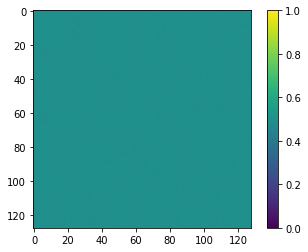

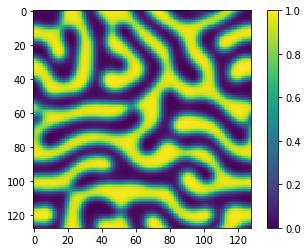

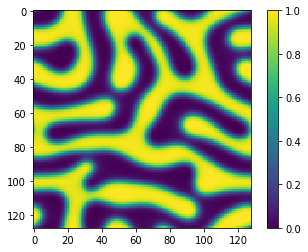

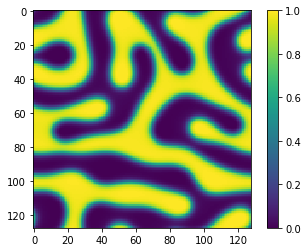

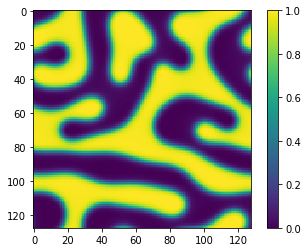

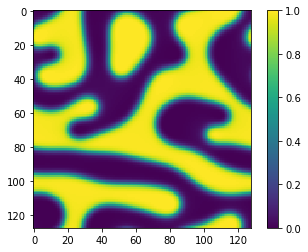

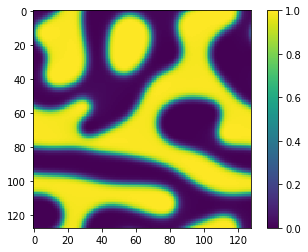

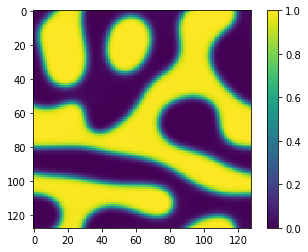

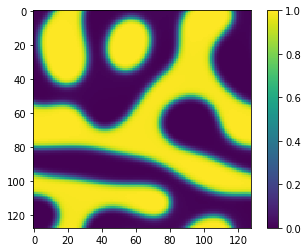

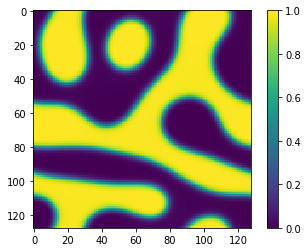

In [113]:
c_pre, c_k_pre = c.copy(), ck.copy()
f_c_pre = f(c, c0_p, c0_m)
f_k_pre = np.fft.rfft2(f_c_pre)
c, ck = simFS1(c, ck)

for i in range(100000):
    if i % 10000 == 0:
        plt.clf()
        plt.imshow(c, vmin=0, vmax=1)
        plt.colorbar()
        plt.pause(0.1)
    c, ck, c_pre, c_k_pre, f_k_pre = simFS2(c, ck, c_pre, c_k_pre, f_k_pre)
    